# Application of Machine Learning Methods to Analysis of Cyber-Sport Events
## Dmitry Savostyanov, 131
## Данный скрипт реализует ранжирование игроков по ролям внутри команды на основе вклада в победу, используя информацию на конец матча (важен порядок, но не абсолютные значения показателей).

### TODO: Для роли Carry модель выдает заниженные результаты.
### Role:
###### 1 - Carry
###### 2 - Mid
###### 3 - Hard-lane
###### 4 - Semi-support
###### 5 - Full-support

### Взаимодействие с Dotabuff:
###### Информация об игроке: https://www.dotabuff.com/esports/players/<'account_id'>

###### Информация о матче: https://www.dotabuff.com/matches/<'match_id'>

###### Информация о команде: https://www.dotabuff.com/esports/teams/<'team_id'>

#### В таблице "Matches & Contributions.csv" представлены матчи за период с 03.03.2017 по 30.04.2017

In [2]:
import urllib2
import json
import random
import datetime

import math 
import pandas as pd 
import numpy as np 
import sklearn 
import matplotlib.pyplot as plt 
 
%matplotlib inline
plt.style.use('ggplot')

# Data Import

In [27]:
sdf_1 = pd.read_csv('ScoresByRole_1.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_2 = pd.read_csv('ScoresByRole_2.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_3 = pd.read_csv('ScoresByRole_3.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_4 = pd.read_csv('ScoresByRole_4.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })
sdf_5 = pd.read_csv('ScoresByRole_5.csv',
                                sep = ';',
                                index_col = 0,
                               dtype = {
                                   '': 'str',
                                   'account_id' : 'str',
                                   'match_id' : 'str', 
                                   'team_id' : 'str', 
                                   'role' : 'str',
                                   'datetime' : 'str', 
                                   'win' : 'bool', 
                                   'win_prob' : 'float64', 
                                   'prediction' : 'bool',
                                   'isCorrect' : 'bool'
                               })

In [28]:
sdf = pd.concat([sdf_1, sdf_2, sdf_3, sdf_4, sdf_5])

In [29]:
matches = sdf.sort_values(by = ['match_id', 'team_id', 'role'], ascending = False)

In [161]:
# matches

# Cumulative Score (match_id + team_id)

In [31]:
cumprob = matches.groupby(['match_id', 'team_id'], as_index=False)['win_prob'].sum()
cumprob.rename(columns = {'win_prob' : 'cumulative_prob'}, inplace = True)

In [162]:
cumprob.sort_values(by = ['match_id', 'cumulative_prob'], ascending = False, inplace = True)
# cumprob

In [37]:
matches = pd.merge(matches, cumprob, on=['match_id', 'team_id'], how='inner')
matches.rename(columns = {'win_prob_x' : 'win_prob', 'win_prob_y' : 'cumulative_prob'}, inplace = True)

In [38]:
matches['win_contribution'] = matches['win_prob'] / matches['cumulative_prob']

In [156]:
# matches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False)

In [54]:
matchesFreq = matches.groupby(['match_id'])['match_id'].count()

In [59]:
len(matchesFreq)

560

#### Избавимся от матчей, которые представлены менее чем 10 записями

In [58]:
fullMatches = matchesFreq[matchesFreq == 10]
len(fullMatches)

207

In [77]:
isFull = np.in1d(matches['match_id'], fullMatches.index.values)

In [79]:
len(isFull)

4930

In [80]:
matches['isFull'] = isFull

In [85]:
sMatches = matches[matches['isFull'] == True]

# Финальная таблица
## Описание полей:
account_id - Идентификатор игрока

match_id - Идентификатор матча

team_id - Идентификатор команды

role - Исполняемая роль (Описание См. Выше)

datetime - Дата окончания матча

win - Идентификатор победы (Целевая переменная)

win_prob - Предсказанная вероятность победы на основе информации по игроку данной роли

prediction - Предсказание со стандартным порогом отсечения (True if win_prob >= 0.5)

isCorrect - Флаг совпадения предсказания с реальностью

cumulative_prob - Сумма вероятностей победы по команде в матче

win_contribution - Вклад игрока данной роли в победу (win_prob / cumulative_prob)

isFull - Флаг того, что для данного match_id в таблице имеется ровно 10 записей (по 5 на команду)

In [86]:
sMatches.sort_values(by = ['match_id', 'team_id', 'cumulative_prob', 'win_contribution'], ascending = False)

,account_id,match_id,team_id,role,datetime,win,win_prob,prediction,isCorrect,cumulative_prob,win_contribution,isFull
3,311360822,3149572447,2586976,2.0,30.04.2017 22:09:06,True,0.998942,True,True,3.151250,0.316999,True
0,94155156,3149572447,2586976,5.0,30.04.2017 22:09:06,True,0.689940,True,True,3.151250,0.218942,True
1,26771994,3149572447,2586976,4.0,30.04.2017 22:09:06,True,0.676170,True,True,3.151250,0.214572,True
2,41231571,3149572447,2586976,3.0,30.04.2017 22:09:06,True,0.577774,True,True,3.151250,0.183348,True
4,19672354,3149572447,2586976,1.0,30.04.2017 22:09:06,True,0.208424,False,False,3.151250,0.066140,True
9,132851371,3149572447,1883502,1.0,30.04.2017 22:09:06,False,0.841920,True,False,1.934337,0.435250,True
5,134556694,3149572447,1883502,5.0,30.04.2017 22:09:06,False,0.662124,True,False,1.934337,0.342300,True
8,106573901,3149572447,1883502,2.0,30.04.2017 22:09:06,False,0.218387,False,True,1.934337,0.112900,True
6,106809101,3149572447,1883502,4.0,30.04.2017 22:09:06,False,0.148795,False,True,1.934337,0.076923,True
7,92423451,3149572447,1883502,3.0,30.04.2017 22:09:06,False,0.063111,False,True,1.934337,0.032627,True


In [158]:
sMatches.to_csv('Matches & Contributions.csv', index = False, na_rep = 'NaN', sep = ';')

# Plots

# EG vs OG
### match: https://www.dotabuff.com/matches/3148721353
### team1: https://www.dotabuff.com/esports/teams/39
### team2: https://www.dotabuff.com/esports/teams/2586976

## EG

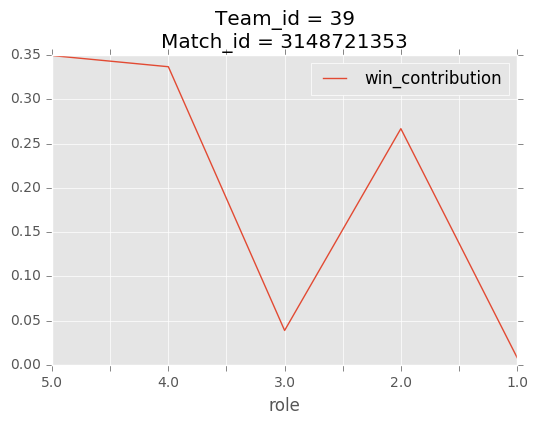

In [154]:
match_id = '3148721353'
team_id = '39'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)

## OG

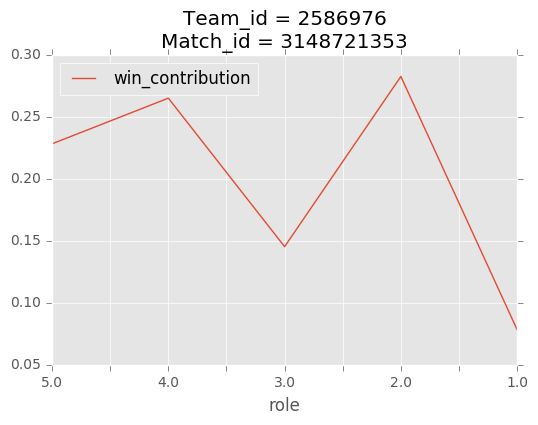

In [155]:
match_id = '3148721353'
team_id = '2586976'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)

# OG vs VP
### match: https://www.dotabuff.com/matches/3149572447
### team1: https://www.dotabuff.com/esports/teams/2586976
### team2: https://www.dotabuff.com/esports/teams/1883502

## OG

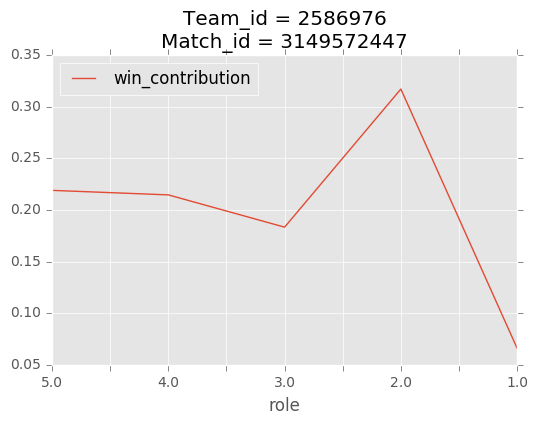

In [159]:
match_id = '3149572447'
team_id = '2586976'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)

## VP

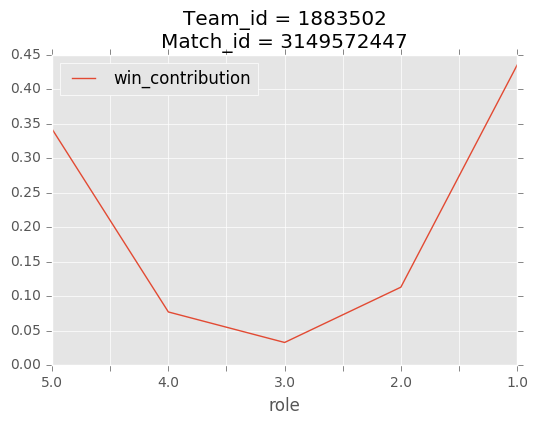

In [145]:
match_id = '3149572447'
team_id = '1883502'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)

# Col vs EG
### match: https://www.dotabuff.com/matches/3033038349
### team1: https://www.dotabuff.com/esports/teams/3
### team2: https://www.dotabuff.com/esports/teams/39

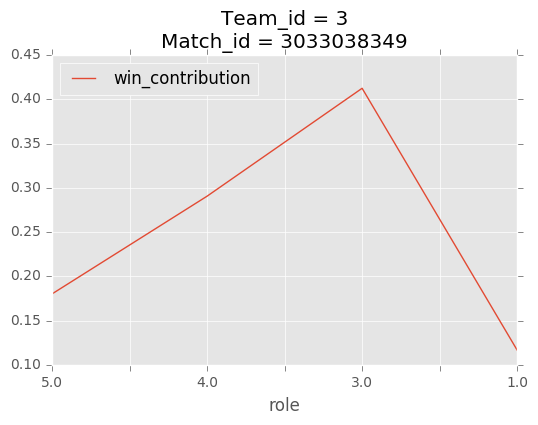

In [160]:
match_id = '3033038349'
team_id = '3'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)

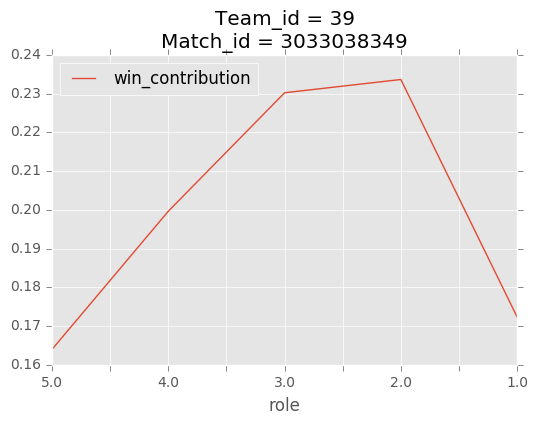

In [147]:
match_id = '3033038349'
team_id = '39'
example = sMatches.loc[(sMatches['match_id'] == match_id) & (sMatches['team_id'] == team_id), :]
picTitle = "Team_id = " + str(example.iloc[0,2]) + "\nMatch_id = " + str(example.iloc[0,1])
example.plot(x = 'role', y = 'win_contribution', legend = True, title = picTitle)